# Within Salish Sea SSC and CIOPS compare

In [1]:
import numpy as np
import xarray as xr
import scipy.interpolate as interp
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import cmocean as cm
import datetime as dt

In [2]:
def get_data(mydata, depthf, section, starttime, endtime):
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    temp = mydata.final_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    sal = mydata.final_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, temp, sal

In [3]:
def get_all_data(file, mymesh):
    
    depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)
    
    yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
    starttime = 1
    endtime = 720
    sections = [0,2,3,4,5,6] #meander, admiralty, deception, rosario, sanjuan, and haro (same for both models)

    depths = np.array([])
    transports = np.array([])
    temp = np.array([])
    sal = np.array([])
    month = np.array([])
    sec = np.array([])

    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, depthf, section, starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            temp = np.append(temp, tempt1)
            sal = np.append(sal, tempt2)
            month = np.append(month, np.full(len(tempD),i+1))
            sec = np.append(sec, np.full(len(tempD),section))
    
    return depths, transports, month, temp, sal, sec

In [4]:
mymesh_SSC = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')

mymesh_CIOPS = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

In [5]:
file_SSC = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan17/ariane_positions_quantitative.nc'
file_CIOPS = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_SS_1yr/forward_01jan17/ariane_positions_quantitative.nc'

In [6]:
depths, transports, month, temp, sal, sec = get_all_data(file_SSC, mymesh_SSC)
d = {'month':month, 'section':sec, 'transport': transports, 'temperature':temp, 'salinity':sal, 'depth':depths}
SSC = pd.DataFrame(data=d)

In [7]:
depths, transports, month, temp, sal, sec = get_all_data(file_CIOPS, mymesh_CIOPS)
d = {'month':month, 'section':sec, 'transport': transports, 'temperature':temp, 'salinity':sal, 'depth':depths}
CIOPS = pd.DataFrame(data=d)

In [8]:
sections = [0,2,3,4,5,6]
sec_names = ['meander', 'admiralty', 'deception', 'rosario', 'sanjuan', 'haro']

In [9]:
np.arange(1,13)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Text(0.5, 0, 'Month')

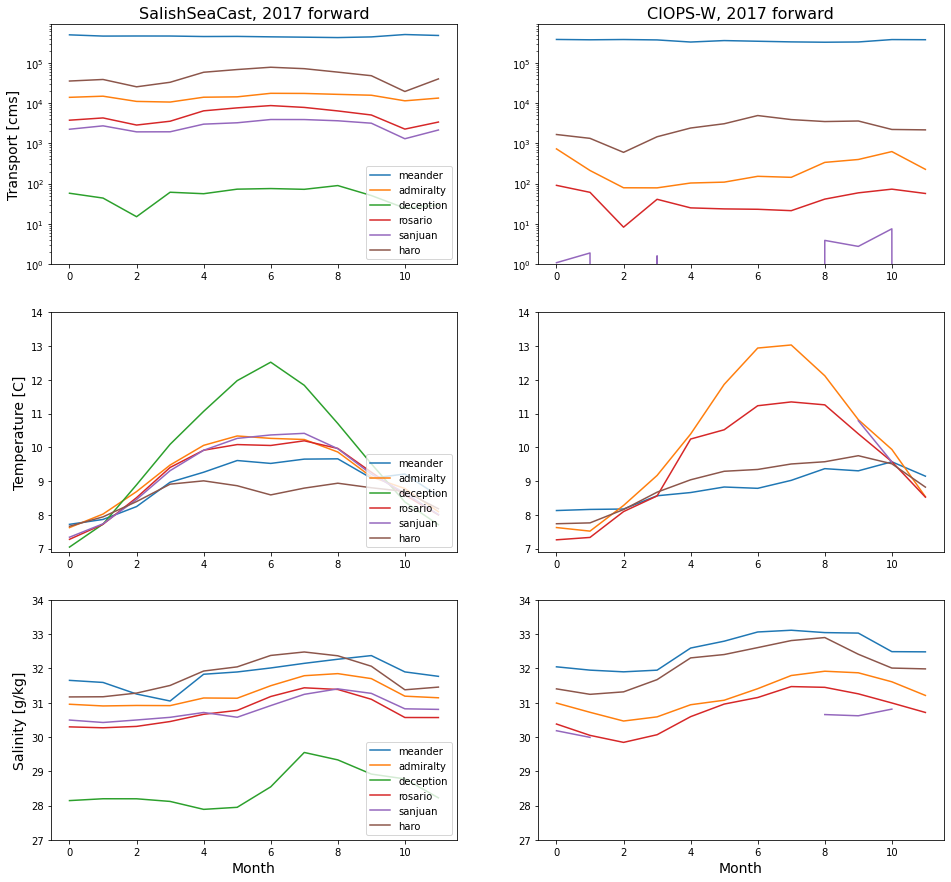

In [10]:
fig, ax = plt.subplots(3,2, figsize=(16,15))

for i in range(len(sections)):
    #transports
    y = [sum(SSC.transport[SSC.section==sections[i]][SSC.month==m]) for m in np.arange(1,13)]
    ax[0,0].plot(y, label=sec_names[i])
    y = [sum(CIOPS.transport[CIOPS.section==sections[i]][CIOPS.month==m]) for m in np.arange(1,13)]
    ax[0,1].plot(y)
    
    #temperature
    y = [np.mean(SSC.temperature[SSC.section==sections[i]][SSC.month==m]) for m in np.arange(1,13)]
    ax[1,0].plot(y, label=sec_names[i])
    y = [np.mean(CIOPS.temperature[CIOPS.section==sections[i]][CIOPS.month==m]) for m in np.arange(1,13)]
    ax[1,1].plot(y)
    
    #salinity
    y = [np.mean(SSC.salinity[SSC.section==sections[i]][SSC.month==m]) for m in np.arange(1,13)]
    ax[2,0].plot(y, label=sec_names[i])
    y = [np.mean(CIOPS.salinity[CIOPS.section==sections[i]][CIOPS.month==m]) for m in np.arange(1,13)]
    ax[2,1].plot(y)
    
ax[0,0].set_yscale('log')
ax[0,0].set_ylim([1,900000])
ax[0,0].legend(loc='lower right')
ax[0,1].set_yscale('log')
ax[0,1].set_ylim([1,900000])

ax[1,0].set_ylim([6.9,14])
ax[1,0].legend(loc='lower right')
ax[1,1].set_ylim([6.9,14])

ax[2,0].set_ylim([27,34])
ax[2,0].legend(loc='lower right')
ax[2,1].set_ylim([27,34])

ax[0,0].set_title('SalishSeaCast, 2017 forward', fontsize=16)
ax[0,1].set_title('CIOPS-W, 2017 forward', fontsize=16)
ax[0,0].set_ylabel('Transport [cms]', fontsize=14)
ax[1,0].set_ylabel('Temperature [C]', fontsize=14)
ax[2,0].set_ylabel('Salinity [g/kg]', fontsize=14)
ax[2,0].set_xlabel('Month', fontsize=14)
ax[2,1].set_xlabel('Month', fontsize=14)

In [11]:
# ok so transport clearly a problem between the 2 - BUT is this because of the max transport versus cell size problem?
# ie. if SSC is 500 m resolution and CIOPS is 2 km, should the max transport be 4x larger in the CIOPS run?

# other thing to note: problem with temp and salinity data missing not as big of an issue in the quantitative runs
# but not not present.... in particular at the cross section of san juan, lets take a deeper look at this cross section

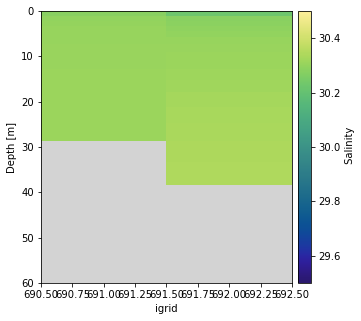

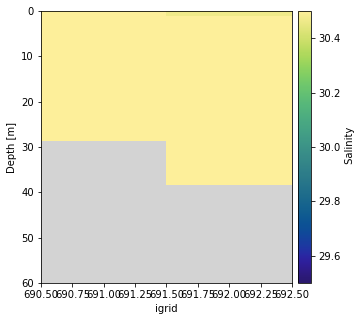

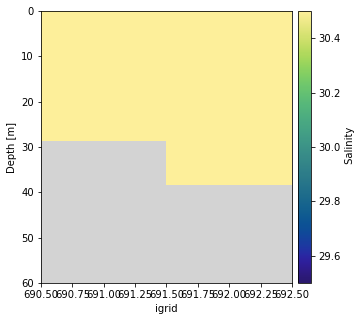

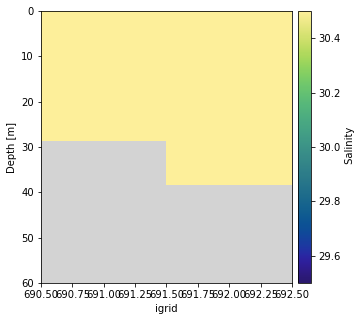

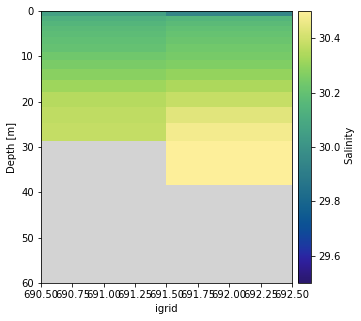

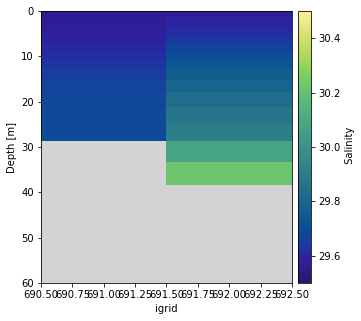

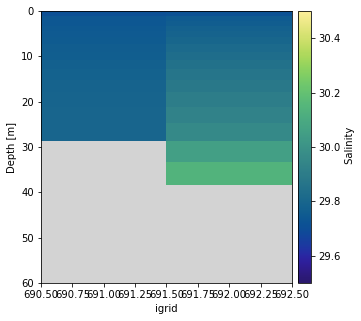

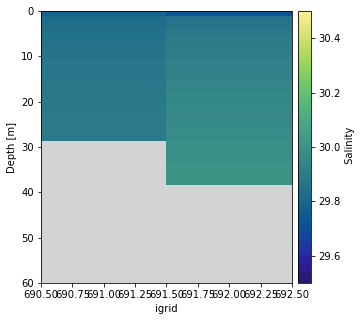

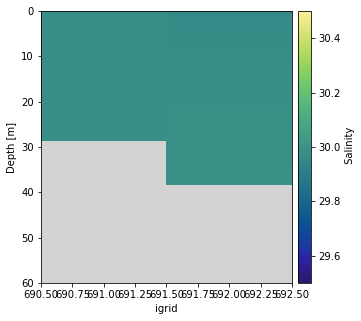

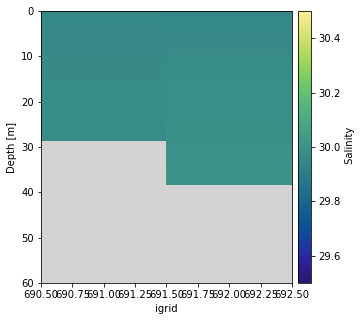

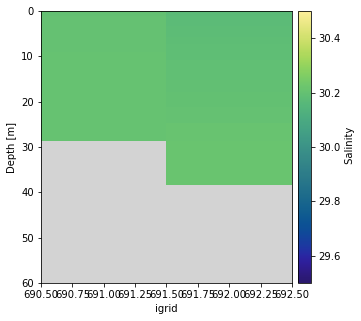

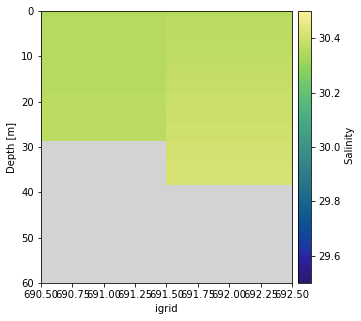

In [12]:
mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

hours = [0]#, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

variable = 'vosaline'

igrid = 277-1
latS = 691
latN = 693
k = 0
months = ['12','11','10','09','08','07','06','05','04','03','02','01']
for mo in months:
    fig, ax= plt.subplots(nrows=1, ncols=1, figsize =(5,5))
    nc_file = '/ocean/rbeutel/data/2017{}/S_new_2017{}12.nc'.format(mo,mo)
    nc_to_plot = nc.Dataset(nc_file)

    data = nc_to_plot[variable][0,:,igrid,latS:latN]
    section_slice = np.arange(latS,latN)
    zlevels = mesh_nc['gdept_1d'][:][0]
    X, Y = np.meshgrid(section_slice, zlevels)
    cmap = cm.cm.haline
    cmap.set_bad('lightgrey')
    tmesh = ax.pcolormesh(X,Y,data, cmap = cm.cm.haline, \
                              vmin = 29.5, vmax = 30.5)

    ax.set_ylim([0,60])
    ax.invert_yaxis()
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('igrid')

    cbar = fig.colorbar(tmesh, ax=ax, orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
    cbar.set_label(label=' Salinity') 
    k+=1

#### not really helpful lol - count nan at every timestep instead..?

In [24]:
count = np.zeros(20*24*12)
k=0
for mo in months:
    for i in range(20):
        data = xr.open_dataset('/ocean/rbeutel/data/2017{}/S_new_2017{}{:02d}.nc'.format(mo,mo,i+1))['vosaline'][:,:,igrid,latS:latN]
        count[k] = np.count_nonzero(np.isnan(data))
        k+=1
count

array([2880., 2880., 2880., ...,    0.,    0.,    0.])

In [27]:
dates = [dt.datetime(2017,1,1)+dt.timedelta(days=i) for i in range(int(365))]

In [37]:
count= [np.count_nonzero(np.isnan(xr.open_dataset('/ocean/rbeutel/data/{:%Y%m}/S_new_{:%Y%m%d}.nc'.format(d,d))['vosaline'][:,:,igrid,latS:latN])) for d in dates]

In [41]:
24*75*2

3600

In [40]:
xr.open_dataset('/ocean/rbeutel/data/{:%Y%m}/S_new_{:%Y%m%d}.nc'.format(dates[0],dates[0]))['vosaline'][:,:,igrid,latS:latN]

<xarray.DataArray 'vosaline' (time_counter: 24, deptht: 75, x: 2)>
array([[[30.145176, 30.12861 ],
        [30.156698, 30.149431],
        ...,
        [      nan,       nan],
        [      nan,       nan]],

       [[30.14586 , 30.12992 ],
        [30.156977, 30.149916],
        ...,
        [      nan,       nan],
        [      nan,       nan]],

       ...,

       [[30.16025 , 30.157387],
        [30.162828, 30.160097],
        ...,
        [      nan,       nan],
        [      nan,       nan]],

       [[30.160934, 30.158695],
        [30.163107, 30.160582],
        ...,
        [      nan,       nan],
        [      nan,       nan]]], dtype=float32)
Coordinates:
  * deptht        (deptht) float32 0.5075 1.558 2.669 ... 5.698e+03 5.902e+03
    nav_lat       (x) float32 ...
    nav_lon       (x) float32 ...
  * time_counter  (time_counter) datetime64[ns] 2017-01-01T01:00:00 ... 2017-...
Dimensions without coordinates: x
Attributes:
    standard_name:       sea_water_salinity
    long_name:           Sea Water Salinity
    units:               0.001
    online_operation:    instant
    interval_operation:  1 d
    interval_write:      1 d
    cell_methods:        time: point